In [1]:
import TXOsim.helpers.sbmlIO as sio
import tellurium as te
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
PATH_TO_MODELS = "./TXOsim/models/"
PATH_TO_OUTPUT = "./TXOsim/output/" # Path for output data, plots
MODELNAME = "TXO"
MODELPY = "TXO.py"
FILENAME = "TXO.csv" # Filename for output data

\begin{align}
&D + R \underset{k_{2}}{\stackrel{k_1}{\rightleftharpoons}} RD \\
&RD + N \underset{k_{4}}{\stackrel{k_3}{\rightleftharpoons}} RDN \overset{k_5}\rightarrow M + D + R \\
&M \overset{k_6}\rightarrow \varnothing
\end{align}

D = DNA
R = polymerase
RD = DNA:polymerase complex
N = NTP
M = mRNA

In [3]:
# Generate ODEs from antimony file
r = te.loada(PATH_TO_MODELS+MODELNAME)
odes = sio.getODEsFromModel(r)
speciesIds, speciesValues, parameterIds, parameterValues, derivatives = sio.parseODEs(r,odes)
sio.writePython(speciesIds,speciesValues,parameterIds,parameterValues,derivatives,PATH_TO_MODELS,MODELPY)
print(odes)


v_J0 = k1*D*R
v_J1 = k2*RD
v_J2 = k3*RD*N
v_J3 = k4*RDN
v_J4 = k5*RDN
v_J5 = k6*M

dD/dt = -v_J0 + v_J1 + v_J4
dR/dt = -v_J0 + v_J1 + v_J4
dRD/dt = v_J0 - v_J1 - v_J2 + v_J3
dN/dt = -v_J2 + v_J3
dRDN/dt = v_J2 - v_J3 - v_J4
dM/dt = v_J4 - v_J5



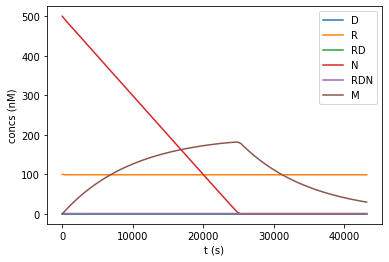

In [4]:
# Solve ODEs 
from TXOsim.models import TXO
y0 = np.array([float(value) for value in speciesValues])
params = np.array([float(value) for value in parameterValues])
TMAX = 12*60*60 # s
NSTEPS = 100

time = np.linspace(0,TMAX,NSTEPS)
sol = odeint(TXO.model, y0, time, args=(params,)) # Scipy solver

# Plot and save plot
for i in range(sol.shape[1]):
    plt.plot(time,sol[:,i], label=speciesIds[i]);
plt.xlabel('t (s)'); plt.ylabel('concs (nM)'); plt.legend()   
plt.savefig(PATH_TO_OUTPUT+'plotTXO.pdf',transparent=True)
plt.show() 

# Save data
df = pd.DataFrame(sol)
df.to_csv(PATH_TO_OUTPUT+FILENAME, index=None)

First:

* What is purpose of model? This should be clear from the start!

* Is this mechanism sufficient? What do we want to explain, and what can we measure experimentally? We do not need to model everything!

Strategy:

1. First discuss **sufficiency of current mechanism** - we want to start from the same page. Does it need an extension? Try to get as **accurate values for parameters** as possible, from literature or better, experimental data: propose some experiments to measure some of these values directly. If neither is possible, then estimate the number, stating assumptions clearly. Whichever is the case, be sure to record what you did and why: there should be no parameters 'pulled out of a hat'. 

2. Then each person investigates **extension to mechanism** to take into account their component. You can work with antimony file or with ODEs directly. We want to be able to get final model in SBML form though - so antimony helps if possible. Investigate fully your model behaviour: systematically vary parameters, see where the model works and where it doesn't. If you have several possible mechanisms to explain your component, even better: you can compare them once we have experimental data and determine which is best.

3. Then everyone comes together, and **integrates the various components into a working device** (we may have multiple devices requiring different components). Again, investigate fully the behaviour of the integrated model. Populate it with reasonable parameters, and use it to make predictions.

4. Compare with experimental data.

We get 'points' for the following:
* Being able to explain where all parameters come from (experiments > literature > estimate)
* Using the model to predict behaviour before an experiment is done (improve experiments with model)
* Using experiments to distinguish good models from bad ones (improve model with experiments)
* Using community-friendly tools (Docker, SBML)
* Accessible code and documentation




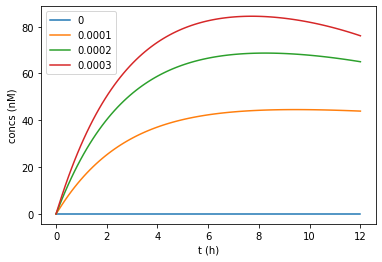

In [5]:
# E.g. an initial condition scan

Ds = [0,1e-4,2e-4,3e-4]

for D in Ds:
    y0 = np.array([float(value) for value in speciesValues])
    params = np.array([float(value) for value in parameterValues])
    params[0] = D # Set DNA concentration to value from array
    TMAX = 12*60*60 # s
    NSTEPS = 100

    time = np.linspace(0,TMAX,NSTEPS)
    sol = odeint(TXO.model, y0, time, args=(params,)) # Scipy solver
    plt.plot(time/(60*60),sol[:,5], label=D)

plt.xlabel('t (h)'); plt.ylabel('concs (nM)'); plt.legend()   
plt.show() 